In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraudulent-e-commerce-transactions/Fraudulent_E-Commerce_Transaction_Data.csv
/kaggle/input/fraudulent-e-commerce-transactions/Fraudulent_E-Commerce_Transaction_Data_2.csv


# Introduction

Hi there! my name is Ahmad Firman, i'm an Electrical Engineering student who wants to become a machine learning engineer oneday. In this project my objectives are to answer these questions:

- Can we identify distinct profiles or characteristics of customers who are more likely to be involved in fraudulent transactions?
- What are the most important features or characteristics that contribute to the likelihood of a transaction being fraudulent?
- Can we build an accurate machine learning model to predict whether a transaction is fraudulent or not?

I am still a beginner so if you found misatakes, or missed steps, or something that i could improve on please let me know, thanks!

# Importing Libraries and Data Wrangling

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint, uniform

In [3]:
df = pd.read_csv("/kaggle/input/fraudulent-e-commerce-transactions/Fraudulent_E-Commerce_Transaction_Data_2.csv")

In [4]:
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,c12e07a0-8a06-4c0d-b5cc-04f3af688570,8ca9f102-02a4-4207-ab63-484e83a1bdf0,42.32,2024-03-24 23:42:43,PayPal,electronics,1,40,East Jameshaven,desktop,110.87.246.85,5399 Rachel Stravenue Suite 718\nNorth Blakebu...,5399 Rachel Stravenue Suite 718\nNorth Blakebu...,0,282,23
1,7d187603-7961-4fce-9827-9698e2b6a201,4d158416-caae-4b09-bd5b-15235deb9129,301.34,2024-01-22 00:53:31,credit card,electronics,3,35,Kingstad,tablet,14.73.104.153,"5230 Stephanie Forge\nCollinsbury, PR 81853","5230 Stephanie Forge\nCollinsbury, PR 81853",0,223,0
2,f2c14f9d-92df-4aaf-8931-ceaf4e63ed72,ccae47b8-75c7-4f5a-aa9e-957deced2137,340.32,2024-01-22 08:06:03,debit card,toys & games,5,29,North Ryan,desktop,67.58.94.93,"195 Cole Oval\nPort Larry, IA 58422","4772 David Stravenue Apt. 447\nVelasquezside, ...",0,360,8
3,e9949bfa-194d-486b-84da-9565fca9e5ce,b04960c0-aeee-4907-b1cd-4819016adcef,95.77,2024-01-16 20:34:53,credit card,electronics,5,45,Kaylaville,mobile,202.122.126.216,"7609 Cynthia Square\nWest Brenda, NV 23016","7609 Cynthia Square\nWest Brenda, NV 23016",0,325,20
4,7362837c-7538-434e-8731-0df713f5f26d,de9d6351-b3a7-4bc7-9a55-8f013eb66928,77.45,2024-01-16 15:47:23,credit card,clothing,5,42,North Edwardborough,desktop,96.77.232.76,"2494 Robert Ramp Suite 313\nRobinsonport, AS 5...","2494 Robert Ramp Suite 313\nRobinsonport, AS 5...",0,116,15


In [5]:
df.describe()

,Transaction Amount,Quantity,Customer Age,Is Fraudulent,Account Age Days,Transaction Hour
count,23634.000000,23634.000000,23634.000000,23634.000000,23634.000000,23634.000000
mean,229.367099,3.000550,34.560210,0.051705,178.660531,11.266015
std,282.046669,1.419663,10.009471,0.221436,107.388682,6.980659
min,10.000000,1.000000,-2.000000,0.000000,1.000000,0.000000
25%,69.070000,2.000000,28.000000,0.000000,84.000000,5.000000
50%,151.415000,3.000000,35.000000,0.000000,178.000000,11.000000
75%,296.127500,4.000000,41.000000,0.000000,272.000000,17.000000
max,9716.500000,5.000000,73.000000,1.000000,365.000000,23.000000


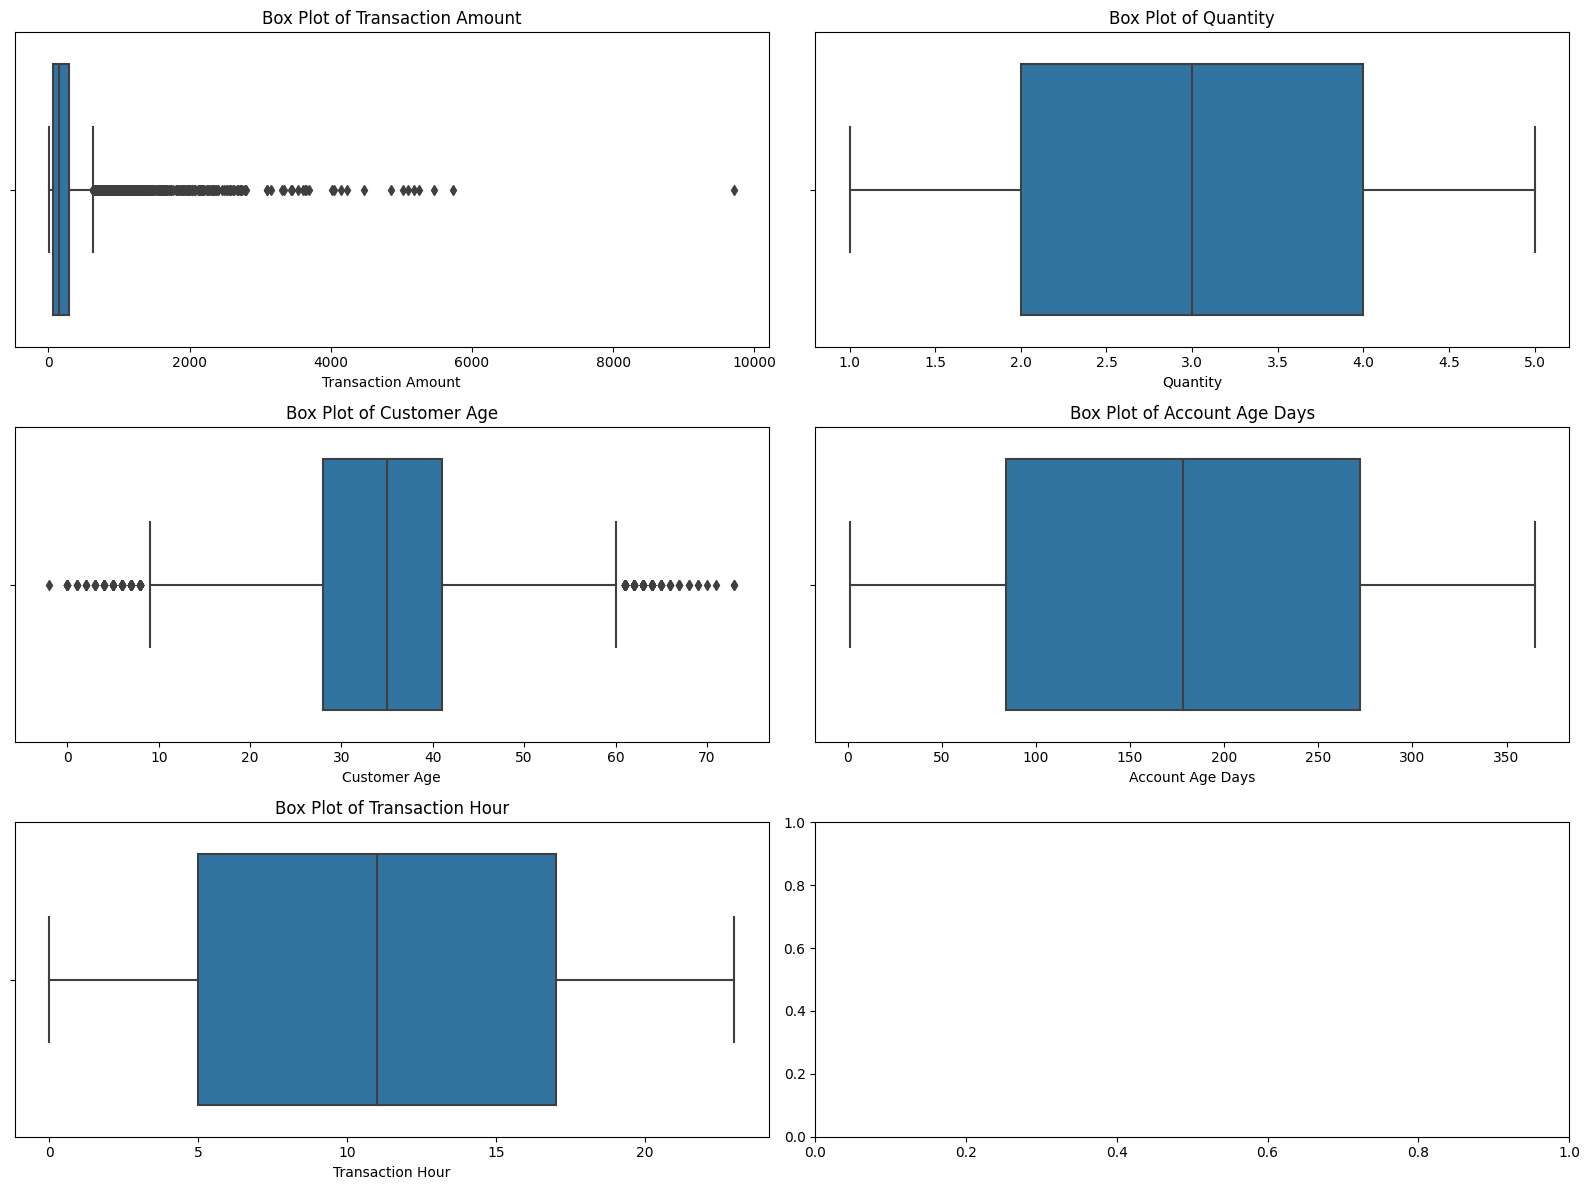

In [6]:
features = ['Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()

look like we got some wrong data in customer age column

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23634 entries, 0 to 23633
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction ID      23634 non-null  object 
 1   Customer ID         23634 non-null  object 
 2   Transaction Amount  23634 non-null  float64
 3   Transaction Date    23634 non-null  object 
 4   Payment Method      23634 non-null  object 
 5   Product Category    23634 non-null  object 
 6   Quantity            23634 non-null  int64  
 7   Customer Age        23634 non-null  int64  
 8   Customer Location   23634 non-null  object 
 9   Device Used         23634 non-null  object 
 10  IP Address          23634 non-null  object 
 11  Shipping Address    23634 non-null  object 
 12  Billing Address     23634 non-null  object 
 13  Is Fraudulent       23634 non-null  int64  
 14  Account Age Days    23634 non-null  int64  
 15  Transaction Hour    23634 non-null  int64  
dtypes: f

In [8]:
df.isna().sum()

Transaction ID        0
Customer ID           0
Transaction Amount    0
Transaction Date      0
Payment Method        0
Product Category      0
Quantity              0
Customer Age          0
Customer Location     0
Device Used           0
IP Address            0
Shipping Address      0
Billing Address       0
Is Fraudulent         0
Account Age Days      0
Transaction Hour      0
dtype: int64

In [9]:
mean_age = df['Customer Age'].mean()
df.loc[df['Customer Age'] < 10, 'Customer Age'] = mean_age

/tmp/ipykernel_18/931540537.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34.56020986714056' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['Customer Age'] < 10, 'Customer Age'] = mean_age


In [10]:
df.describe()

,Transaction Amount,Quantity,Customer Age,Is Fraudulent,Account Age Days,Transaction Hour
count,23634.000000,23634.000000,23634.000000,23634.000000,23634.000000,23634.000000
mean,229.367099,3.000550,34.741608,0.051705,178.660531,11.266015
std,282.046669,1.419663,9.746543,0.221436,107.388682,6.980659
min,10.000000,1.000000,10.000000,0.000000,1.000000,0.000000
25%,69.070000,2.000000,28.000000,0.000000,84.000000,5.000000
50%,151.415000,3.000000,35.000000,0.000000,178.000000,11.000000
75%,296.127500,4.000000,41.000000,0.000000,272.000000,17.000000
max,9716.500000,5.000000,73.000000,1.000000,365.000000,23.000000


In [11]:
df.duplicated().sum()

0

In [12]:
df.columns

Index(['Transaction ID', 'Customer ID', 'Transaction Amount',
       'Transaction Date', 'Payment Method', 'Product Category', 'Quantity',
       'Customer Age', 'Customer Location', 'Device Used', 'IP Address',
       'Shipping Address', 'Billing Address', 'Is Fraudulent',
       'Account Age Days', 'Transaction Hour'],
      dtype='object')

In this project we will drop some column like Transcation ID, Customer ID, Transaction Date,Customer Location,Shipping Address, Billing Address, and IP Address so we can focus to our objectives. But before we dropping the columns i want to make a new column named "Address Match" to get if the Shipping address is the same or not to the Billing Address.

In [13]:
df['Address Match'] = (df['Shipping Address'] == df['Billing Address']).astype(int)

In [14]:
df = df.drop(["Transaction ID","Customer ID","Customer Location","Transaction Date","IP Address","Shipping Address","Billing Address"], axis=1)

In [15]:
df.head()

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Is Fraudulent,Account Age Days,Transaction Hour,Address Match
0,42.32,PayPal,electronics,1,40.0,desktop,0,282,23,1
1,301.34,credit card,electronics,3,35.0,tablet,0,223,0,1
2,340.32,debit card,toys & games,5,29.0,desktop,0,360,8,0
3,95.77,credit card,electronics,5,45.0,mobile,0,325,20,1
4,77.45,credit card,clothing,5,42.0,desktop,0,116,15,1


# Exploratory Data Analysis

## Features Understanding

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


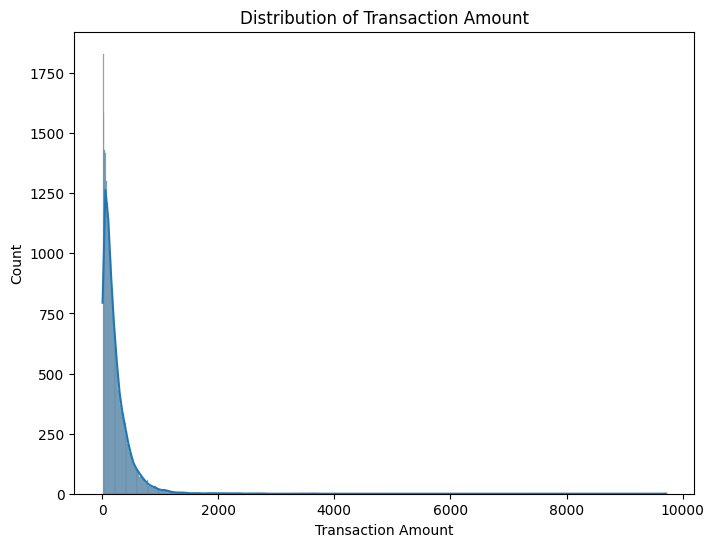

In [16]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Transaction Amount'], kde=True)
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Distribution of Transaction Amount')
plt.show()

that is very sweked

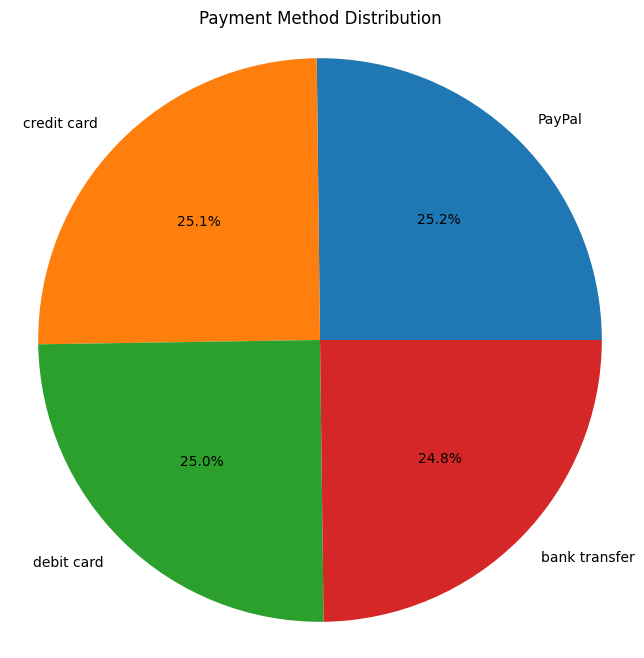

In [17]:
plt.figure(figsize=(8, 8))
plt.pie(df['Payment Method'].value_counts(), labels=df['Payment Method'].unique(), autopct='%1.1f%%')
plt.title('Payment Method Distribution')
plt.axis('equal')
plt.show()

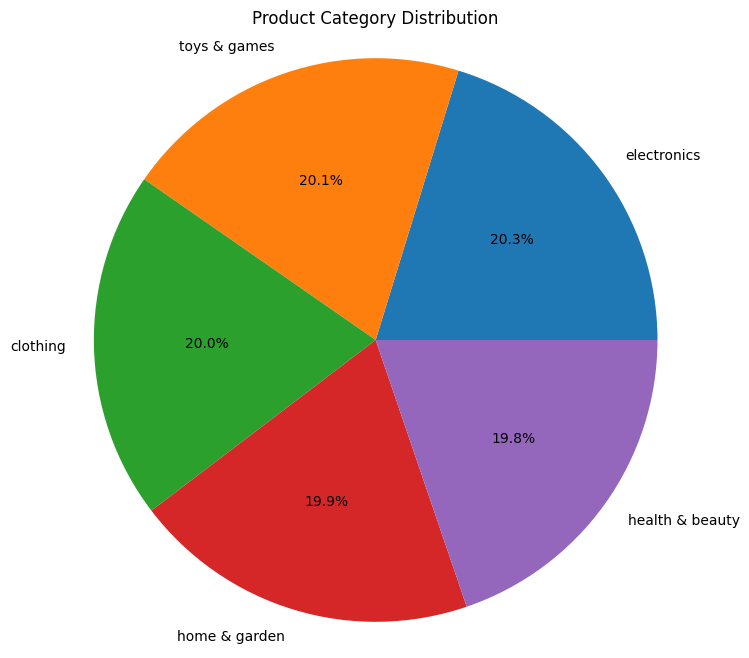

In [18]:
plt.figure(figsize=(8, 8))
plt.pie(df['Product Category'].value_counts(), labels=df['Product Category'].unique(), autopct='%1.1f%%')
plt.title('Product Category Distribution')
plt.axis('equal')
plt.show()

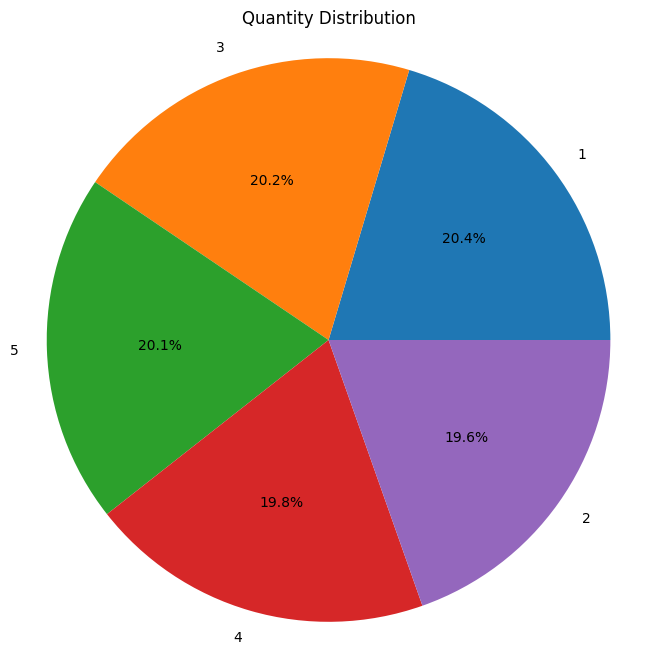

In [19]:
plt.figure(figsize=(8, 8))
plt.pie(df['Quantity'].value_counts(), labels=df['Quantity'].unique(), autopct='%1.1f%%')
plt.title('Quantity Distribution')
plt.axis('equal')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


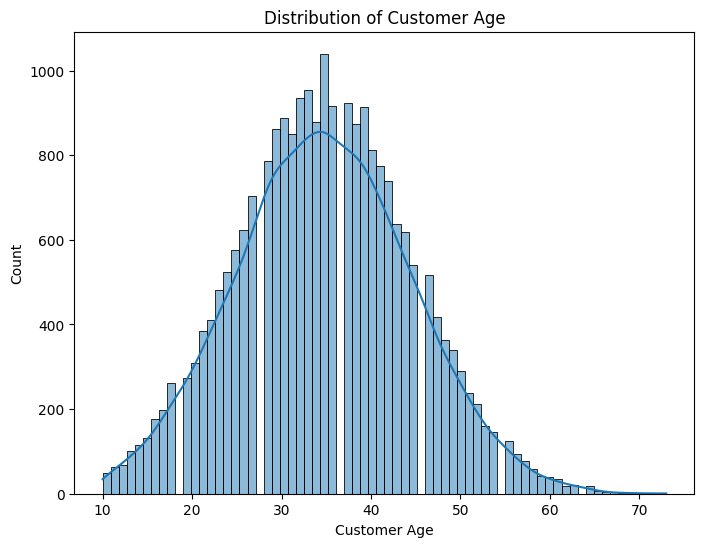

In [20]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Customer Age'], kde=True)
plt.xlabel('Customer Age')
plt.ylabel('Count')
plt.title('Distribution of Customer Age')
plt.show()

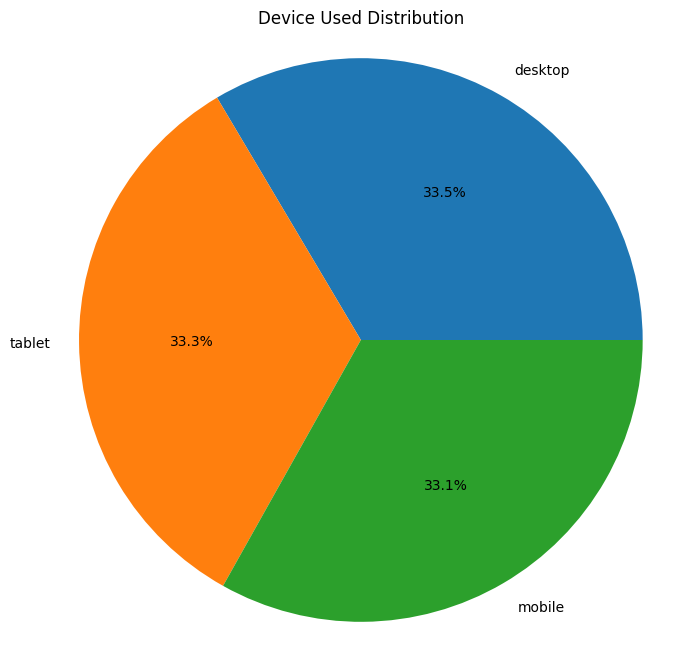

In [21]:
plt.figure(figsize=(8, 8))
plt.pie(df['Device Used'].value_counts(), labels=df['Device Used'].unique(), autopct='%1.1f%%')
plt.title('Device Used Distribution')
plt.axis('equal')
plt.show()

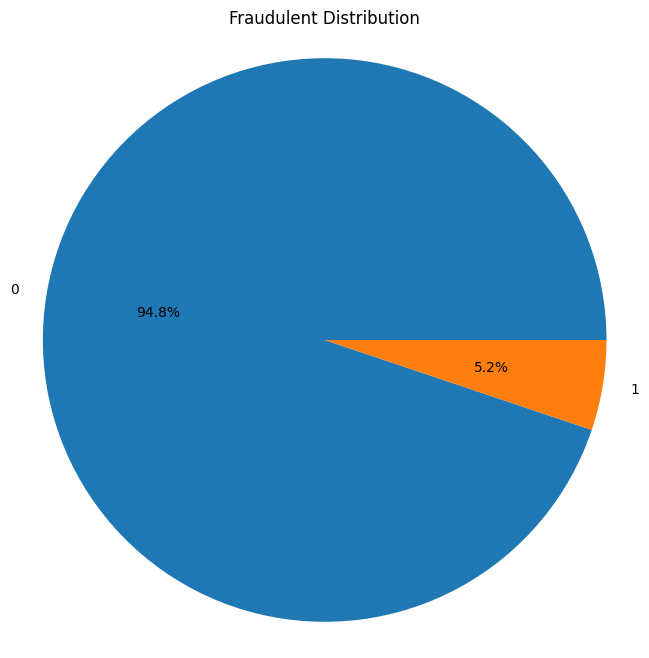

In [22]:
plt.figure(figsize=(8, 8))
plt.pie(df['Is Fraudulent'].value_counts(), labels=df['Is Fraudulent'].unique(), autopct='%1.1f%%')
plt.title('Fraudulent Distribution')
plt.axis('equal')
plt.show()

looks like we got imbalance, we need to deal with it later.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


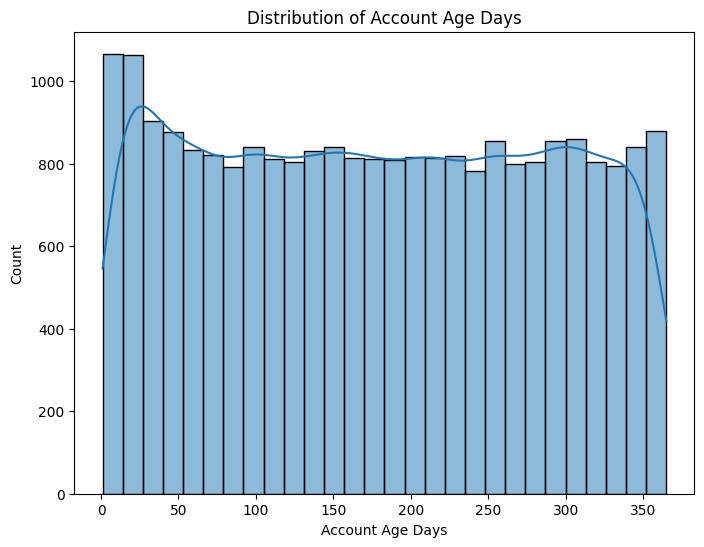

In [23]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Account Age Days'], kde=True)
plt.xlabel('Account Age Days')
plt.ylabel('Count')
plt.title('Distribution of Account Age Days')
plt.show()

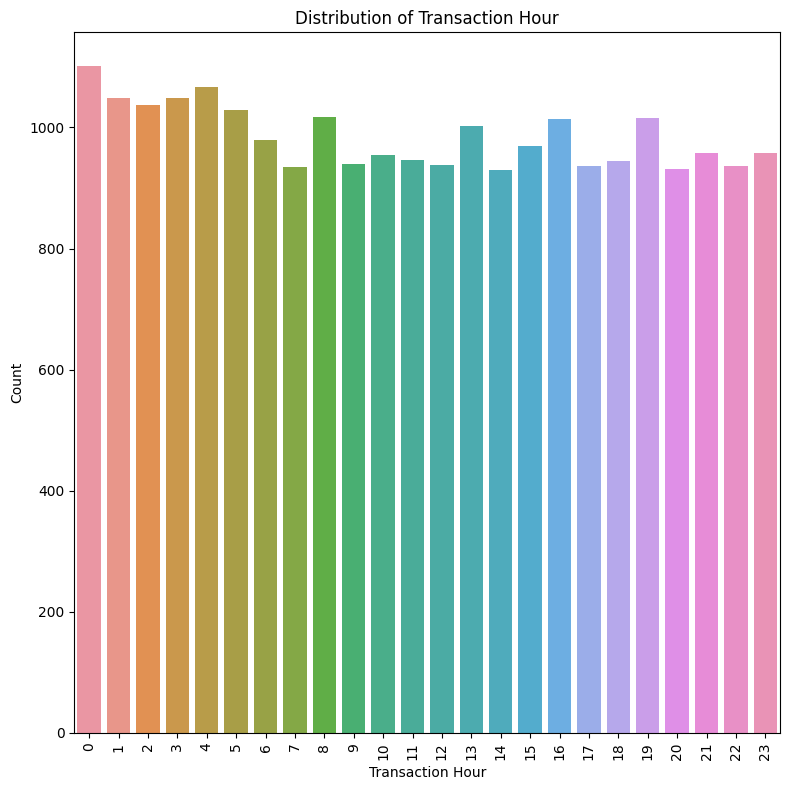

In [24]:
plt.figure(figsize=(8, 8))
sns.countplot(x='Transaction Hour', data=df)
plt.xlabel('Transaction Hour')
plt.ylabel('Count')
plt.title('Distribution of Transaction Hour')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

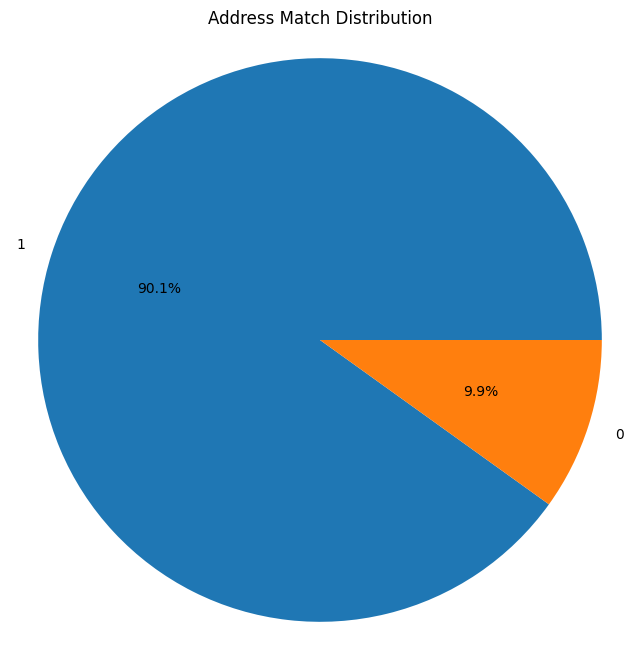

In [25]:
plt.figure(figsize=(8, 8))
plt.pie(df['Address Match'].value_counts(), labels=df['Address Match'].unique(), autopct='%1.1f%%')
plt.title('Address Match Distribution')
plt.axis('equal')
plt.show()

## Features Relationship

here we will answer the first and the second question "Can we identify distinct profiles or characteristics of customers who are more likely to be involved in fraudulent transactions?" and "What are the most important features or characteristics that contribute to the likelihood of a transaction being fraudulent?"

In [26]:
fraud_groups = df.groupby('Is Fraudulent')

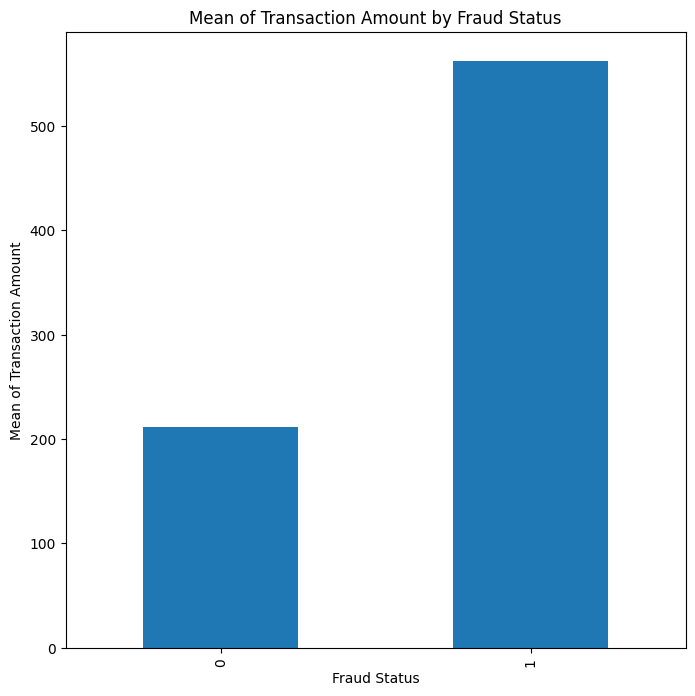

In [27]:
feature_mean = fraud_groups['Transaction Amount'].mean()
plt.figure(figsize=(8, 8))
feature_mean.plot(kind='bar')
plt.xlabel('Fraud Status')
plt.ylabel('Mean of Transaction Amount')
plt.title('Mean of Transaction Amount by Fraud Status')
plt.show()

Text(0.5, 1.0, 'Fraudulent Distribution Based on Payment Method')

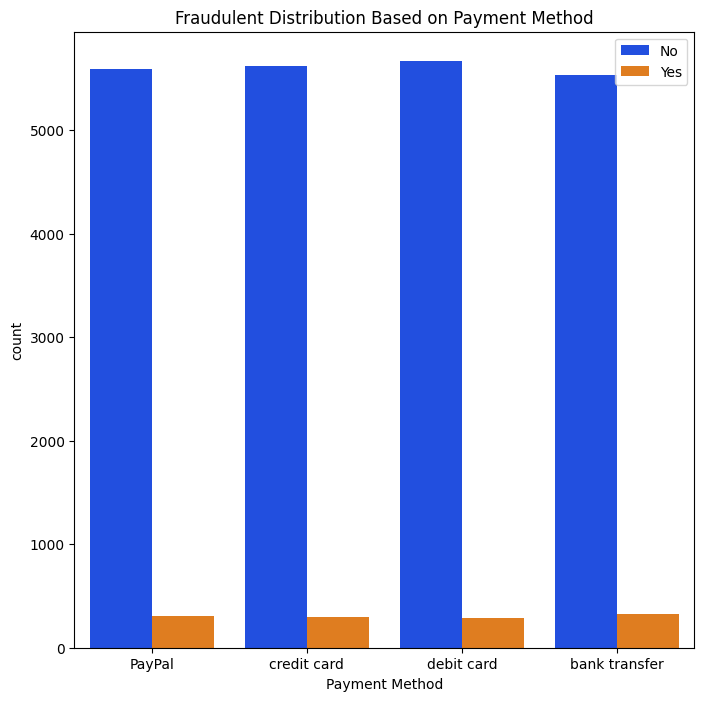

In [28]:
plt.figure(figsize=(8,8))
sns.countplot(x="Payment Method", data=df, palette='bright',hue='Is Fraudulent')
plt.legend(['No','Yes'])
plt.title('Fraudulent Distribution Based on Payment Method')

Text(0.5, 1.0, 'Fraudulent Distribution Based on Product Category')

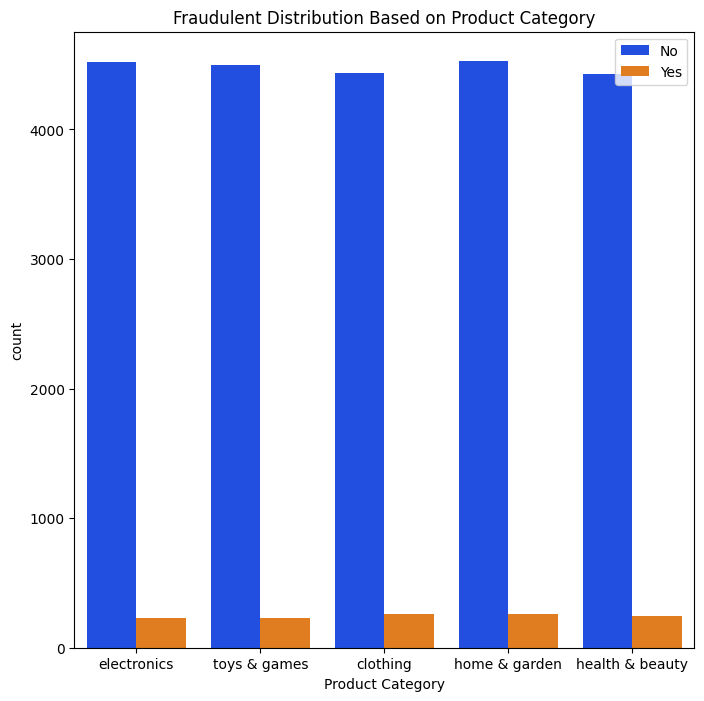

In [29]:
plt.figure(figsize=(8,8))
sns.countplot(x="Product Category", data=df, palette='bright',hue='Is Fraudulent')
plt.legend(['No','Yes'])
plt.title('Fraudulent Distribution Based on Product Category')

Text(0.5, 1.0, 'Fraudulent Distribution Based on Quantity')

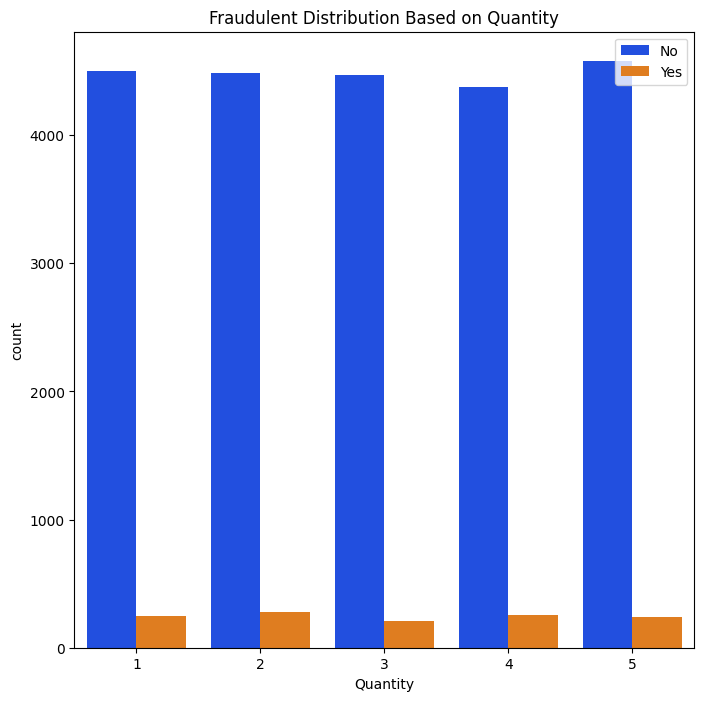

In [30]:
plt.figure(figsize=(8,8))
sns.countplot(x="Quantity", data=df, palette='bright',hue='Is Fraudulent')
plt.legend(['No','Yes'])
plt.title('Fraudulent Distribution Based on Quantity')

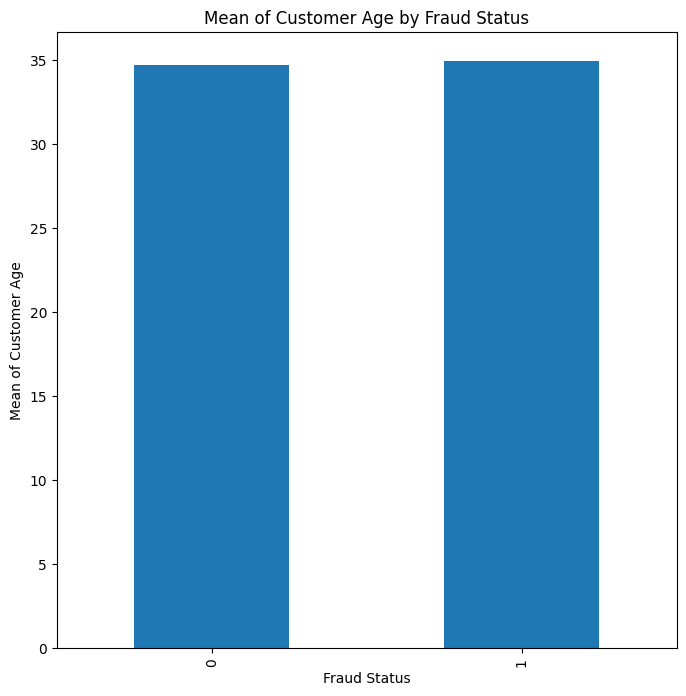

In [31]:
feature_mean = fraud_groups['Customer Age'].mean()
plt.figure(figsize=(8, 8))
feature_mean.plot(kind='bar')
plt.xlabel('Fraud Status')
plt.ylabel('Mean of Customer Age')
plt.title('Mean of Customer Age by Fraud Status')
plt.show()

Text(0.5, 1.0, 'Fraudulent Distribution Based on Device Used')

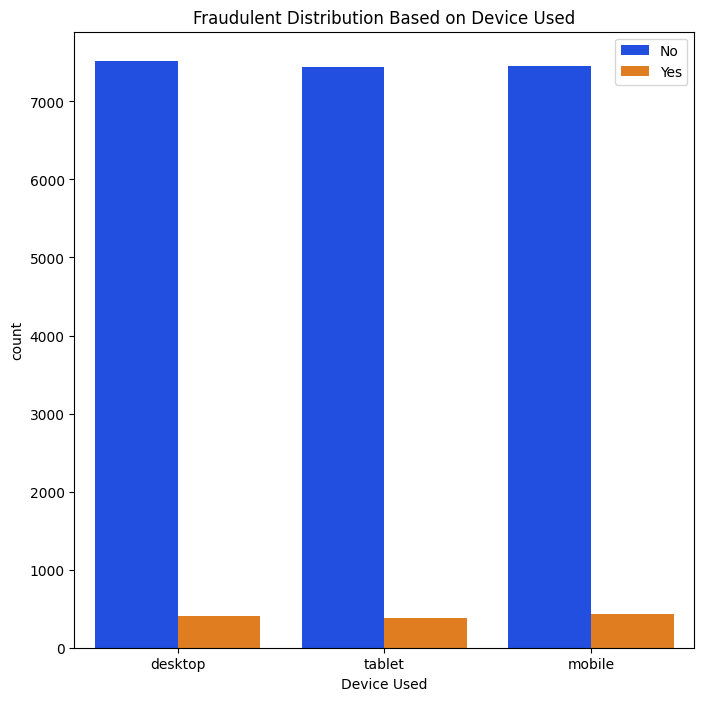

In [32]:
plt.figure(figsize=(8,8))
sns.countplot(x="Device Used", data=df, palette='bright',hue='Is Fraudulent')
plt.legend(['No','Yes'])
plt.title('Fraudulent Distribution Based on Device Used')

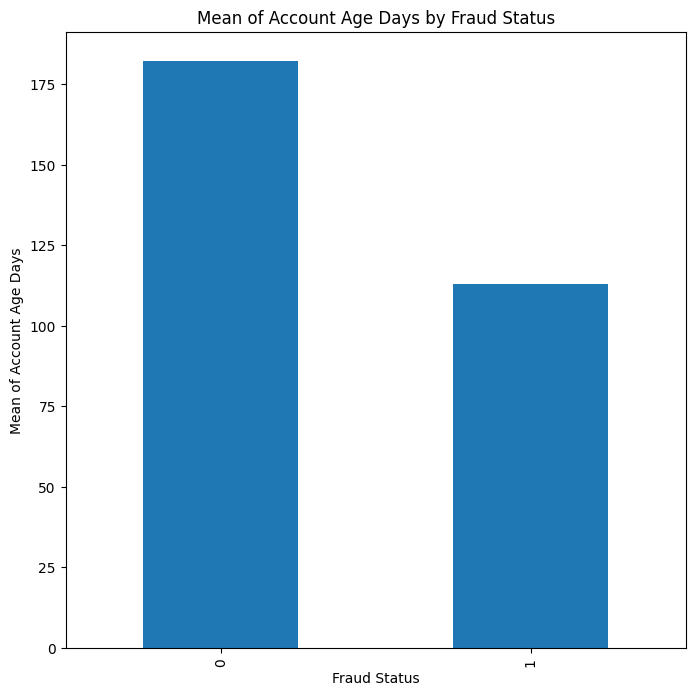

In [33]:
feature_mean = fraud_groups['Account Age Days'].mean()
plt.figure(figsize=(8, 8))
feature_mean.plot(kind='bar')
plt.xlabel('Fraud Status')
plt.ylabel('Mean of Account Age Days')
plt.title('Mean of Account Age Days by Fraud Status')
plt.show()

Text(0.5, 1.0, 'Fraudulent Distribution Based on Transaction Hour')

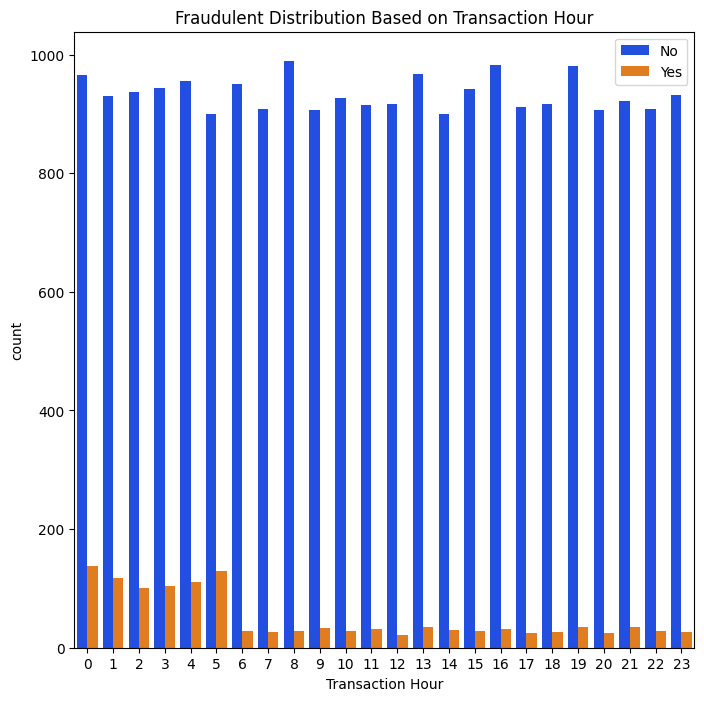

In [34]:
plt.figure(figsize=(8,8))
sns.countplot(x="Transaction Hour", data=df, palette='bright',hue='Is Fraudulent')
plt.legend(['No','Yes'])
plt.title('Fraudulent Distribution Based on Transaction Hour')

Text(0.5, 1.0, 'Fraudulent Distribution Based on Address Match')

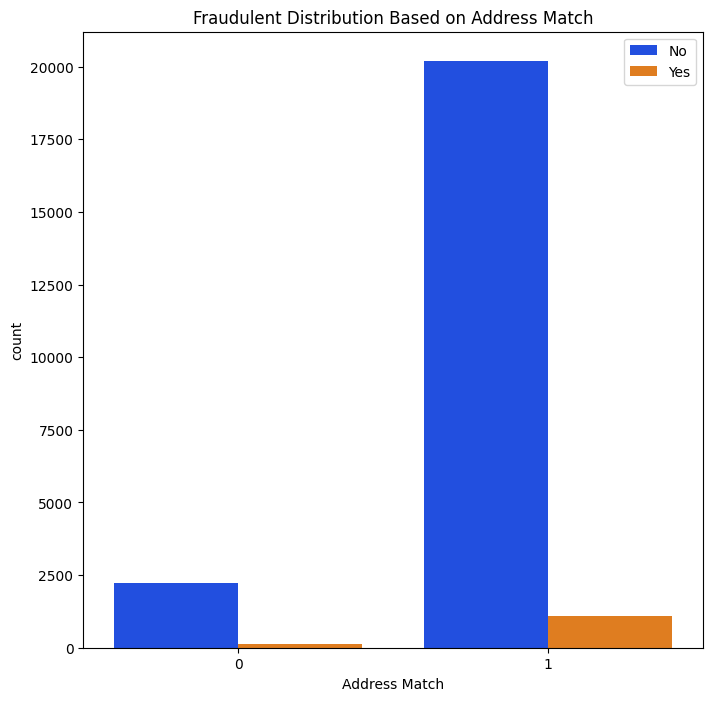

In [35]:
plt.figure(figsize=(8,8))
sns.countplot(x="Address Match", data=df, palette='bright',hue='Is Fraudulent')
plt.legend(['No','Yes'])
plt.title('Fraudulent Distribution Based on Address Match')

The plots is not giving enough information because the fraudulent transaction is very small than the non fraudulent transaction. But we can quite identify distict profiles of customers who are more likely to be involved in fraudulent transactions.
- Firstly we can see on the plot where the mean of the transaction is estimated above 220$ is more likely to identify as fraudulent
- then we can see, if the mean of the account age is below 125 days will be identify as fraudulent
- and lastly we can see the fraudulent transaction is most likely in hour 0 to 5

## Dealing with Categorical Data

In [36]:
categorical = df.select_dtypes(include=['object']).columns.tolist()
categorical

['Payment Method', 'Product Category', 'Device Used']

In [37]:
df['Payment Method'].value_counts()

Payment Method
debit card       5952
credit card      5923
PayPal           5899
bank transfer    5860
Name: count, dtype: int64

In [38]:
df['Payment Method'] = df['Payment Method'].map({"debit card":0,"credit card":1,"PayPal":2,"bank transfer":3})

In [39]:
df['Product Category'].value_counts()

Product Category
home & garden      4786
electronics        4748
toys & games       4730
clothing           4699
health & beauty    4671
Name: count, dtype: int64

In [40]:
df['Product Category'] = df['Product Category'].map({"home & garden":0,"electronics":1,"toys & games":2,"clothing":3,"health & beauty":4})

In [41]:
df['Device Used'].value_counts()

Device Used
desktop    7923
mobile     7881
tablet     7830
Name: count, dtype: int64

In [42]:
df['Device Used'] = df['Device Used'].map({"desktop":0,"mobile":1,"tablet":2,})

In [43]:
new_column_order = ['Transaction Amount', 'Payment Method', 'Product Category', 'Quantity',
                   'Customer Age', 'Device Used','Address Match' , 'Account Age Days',
                   'Transaction Hour','Is Fraudulent']
df = df.reindex(columns=new_column_order)
df

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Address Match,Account Age Days,Transaction Hour,Is Fraudulent
0,42.32,2,1,1,40.00000,0,1,282,23,0
1,301.34,1,1,3,35.00000,2,1,223,0,0
2,340.32,0,2,5,29.00000,0,0,360,8,0
3,95.77,1,1,5,45.00000,1,1,325,20,0
4,77.45,1,3,5,42.00000,0,1,116,15,0
...,...,...,...,...,...,...,...,...,...,...
23629,53.73,2,2,5,32.00000,2,1,363,16,0
23630,47.42,1,3,4,41.00000,0,1,296,17,0
23631,1045.23,3,4,1,34.56021,2,1,329,23,0
23632,34.25,0,0,2,39.00000,1,1,347,11,0


In [44]:
numeric_features = ['Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour']
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])
df.head()

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Address Match,Account Age Days,Transaction Hour,Is Fraudulent
0,-0.663192,2,1,-1.409202,0.539525,0,1,0.962314,1.680964,0
1,0.255186,1,1,-0.000387,0.026512,2,1,0.412896,-1.613924,0
2,0.393393,0,2,1.408427,-0.589104,0,0,1.688663,-0.467876,0
3,-0.473680,1,1,1.408427,1.052538,1,1,1.362737,1.251196,0
4,-0.538635,1,3,1.408427,0.744730,0,1,-0.583505,0.534916,0


<Axes: >

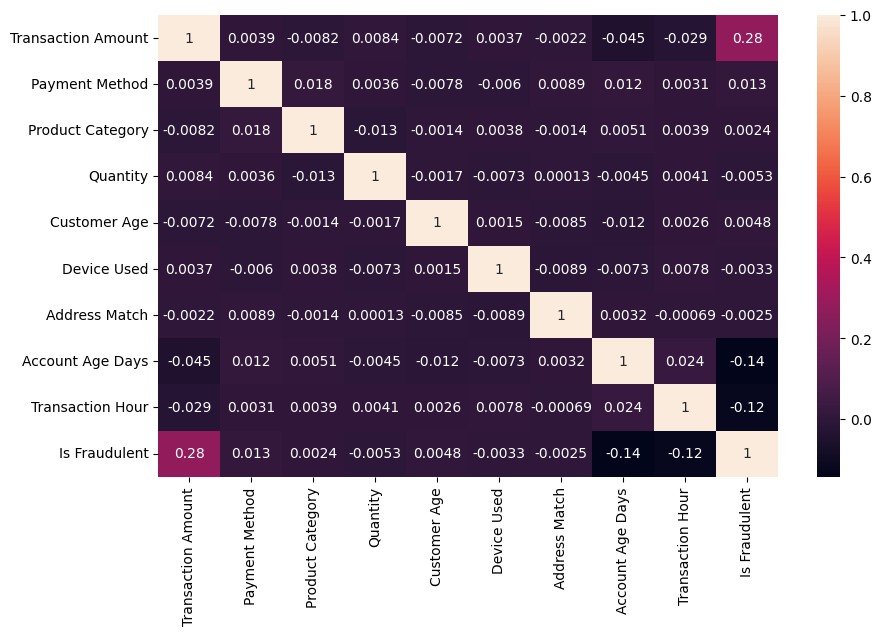

In [45]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),annot=True)

the heatmap shows that transaction amount is the most important characteristic that contribute to likelihood transtaction being fraudulent or not, but the correlation between the features doesn't show much.

# Modeling the data

## Handling Imbalance

In [46]:
X = df.drop('Is Fraudulent', axis=1)
y = df['Is Fraudulent']
X.shape, y.shape

((23634, 9), (23634,))

In [47]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
print(X_resampled.shape,y_resampled.shape)

(44824, 9) (44824,)


In [48]:
rus = RandomUnderSampler(sampling_strategy='majority')
X_under_resampled, y_under_resampled = rus.fit_resample(X, y)
print(X_under_resampled.shape,y_under_resampled.shape)

(2444, 9) (2444,)


In [49]:
print(y_resampled.value_counts())
print(y_under_resampled.value_counts())

Is Fraudulent
0    22412
1    22412
Name: count, dtype: int64
Is Fraudulent
0    1222
1    1222
Name: count, dtype: int64


In [50]:
# Random Under Sampler
X_train,X_test,y_train,y_test = train_test_split(X_under_resampled,y_under_resampled,test_size=0.2,random_state=42)
model = RandomForestClassifier(random_state=1234)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.81      0.77       248
           1       0.78      0.71      0.75       241

    accuracy                           0.76       489
   macro avg       0.76      0.76      0.76       489
weighted avg       0.76      0.76      0.76       489



In [51]:
# SMOTE
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4555
           1       0.96      0.97      0.97      4410

    accuracy                           0.97      8965
   macro avg       0.97      0.97      0.97      8965
weighted avg       0.97      0.97      0.97      8965



# Conclusion

Based on the result, our model has great performance with overall accuracy of 97% with balanced precision, recall, and F1-score values of around 0.96-0.97 for both the target classes. thought with undersampling we got 74% accuracy.